# Imports

In [110]:
import numpy as np
import pandas as pd
import glob
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from random import sample, shuffle, seed
from scipy import stats
import matplotlib.pyplot as plt
import stopwordsiso as stopwords

# Set random seed
seed(5)

In [111]:
def get_df_from_path(path):
    '''
    Concatenate all CSV files in the specified path and return
    the result as a DataFrame.

    @param path (str): path to input CSV files
    @return (DataFrame): DataFrame containing all data
    '''
  
    all_files = glob.glob(path)

    # Concatenate all CSVs in the specified path into one DataFrame
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    if li == []:
        return None

    df = pd.concat(li, axis=0, ignore_index=True)
    return df

In [112]:
# Load Google's pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format(
    './GoogleNews-vectors-negative300.bin', binary=True)

In [113]:
# Get DataFrame of samples
samples = get_df_from_path('csv/*/*_comp.csv')

# Get the list of complements
words = list(samples['Complement Lemma'])

# Ensure words are present in Google's Word2Vec dictionary and not a stopword
words = [w for w in words if w in model if w not in stopwords.stopwords("en")]
# Shuffle words
shuffle(words)

# Get vectors for complements
complement_vectors = model[words]
print(complement_vectors.shape)


(493, 300)


In [114]:
# Fit K-means model with 30 clusters to the complement vectors
kmeans = KMeans(n_clusters=30, random_state=0).fit(complement_vectors)

# Obtain mapping from cluster numbers to the words contained within them
cluster_to_word_list = defaultdict(list)
for w, c in enumerate(kmeans.labels_):
    cluster_to_word_list[c].append(words[w])

# Number of words in cluster to sample for observation
sample_size = 5

data = []

for i, centroid in enumerate(kmeans.cluster_centers_):

    # Get all the words in the cluster as a list
    words_in_cluster = list(cluster_to_word_list[i])
    cluster_word_count = len(words_in_cluster)
    unique_words_in_cluster = list(set(words_in_cluster))
    unique_word_count = len(unique_words_in_cluster)

    # Get top 5 words close to the centroid
    centroid_words = list(
        zip(*model.most_similar(positive=[centroid], topn=100)))[0]

    # Get a sample of words in the cluster
    if len(unique_words_in_cluster) < sample_size:
        sample_words = unique_words_in_cluster.copy()
    else:
        sample_words = sample(unique_words_in_cluster,
                              k=sample_size)

    # Append to data
    data.append([cluster_word_count, list(centroid_words), sample_words, unique_words_in_cluster])


In [115]:
# Make DataFrame
df = pd.DataFrame(data, columns=['Cluster Word Count', 'Centroid Words', 'Sample Words', 'All Words'])
df.to_csv('clusters-no-filter.csv')
df

,Cluster Word Count,Centroid Words,Sample Words,All Words
0,3,"[coup, coup_d'_etat, coup_d'_état, putsch, blo...",[coup],[coup]
1,5,"[entry, metastasis, breast, metastases, recurr...","[metastasis, breast, entry, advance]","[metastasis, breast, entry, advance]"
2,29,"[trip, stopover, trips, excursion, jaunt, sojo...","[flight, tour, travel, trip, pilgrimage]","[pilgrimage, tour, stopover, travel, flight, t..."
3,16,"[word, phrase, words, language, verb, verb_ten...","[word, reference, lyric, scribble, grammar]","[lyric, reference, grammar, message, word, lan..."
4,180,"[By_Jonas_Elmerraji, %_#F########_7v.jsn, %_#F...","[experience, war, leaf, comparison, brick]","[glowstick, cream, border, collection, mold, d..."
5,12,"[noise, ambient_noise, Noise, noises, loud_noi...","[noise, sound]","[noise, sound]"
6,25,"[sense, impression, humor_Jena_Elayan, feel, t...","[sense, assumption, haste, representation, sac...","[concern, assumption, impression, lot, represe..."
7,25,"[change, changes, changing, adjustment, alter,...","[alteration, revision, change, transition, adj...","[alteration, transition, adjustment, revision,..."
8,20,"[decision, recommendation, decison, announceme...","[conclusion, announcement, request, decision, ...","[decision, submission, proposal, recommendatio..."
9,3,"[statue, bronze_statue, sculpture, statues, br...","[statue, sculpture]","[statue, sculpture]"


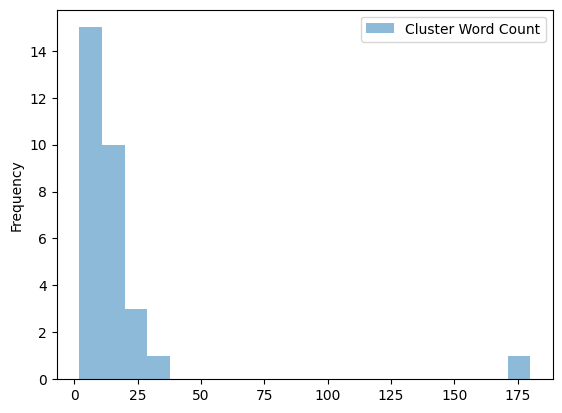

In [116]:
# Let's visualize the cluster size distribution
ax = df.plot.hist(bins=20, alpha=0.5)

In [117]:
# Since the distribution is not Gaussian, we just use quantiles
# for outlier removal

q_low = df['Cluster Word Count'].quantile(0.05)
q_hi = df['Cluster Word Count'].quantile(0.95)

df_filtered = df[(df['Cluster Word Count'] < q_hi) &
                 (df['Cluster Word Count'] > q_low)]
print('New number of clusters:', len(df_filtered))
df_filtered.to_csv('clusters-filter.csv')
df_filtered


New number of clusters: 26


,Cluster Word Count,Centroid Words,Sample Words,All Words
0,3,"[coup, coup_d'_etat, coup_d'_état, putsch, blo...",[coup],[coup]
1,5,"[entry, metastasis, breast, metastases, recurr...","[metastasis, breast, entry, advance]","[metastasis, breast, entry, advance]"
3,16,"[word, phrase, words, language, verb, verb_ten...","[word, reference, lyric, scribble, grammar]","[lyric, reference, grammar, message, word, lan..."
5,12,"[noise, ambient_noise, Noise, noises, loud_noi...","[noise, sound]","[noise, sound]"
6,25,"[sense, impression, humor_Jena_Elayan, feel, t...","[sense, assumption, haste, representation, sac...","[concern, assumption, impression, lot, represe..."
7,25,"[change, changes, changing, adjustment, alter,...","[alteration, revision, change, transition, adj...","[alteration, transition, adjustment, revision,..."
8,20,"[decision, recommendation, decison, announceme...","[conclusion, announcement, request, decision, ...","[decision, submission, proposal, recommendatio..."
9,3,"[statue, bronze_statue, sculpture, statues, br...","[statue, sculpture]","[statue, sculpture]"
10,13,"[friend, mother, daughter, grandmother, aunt, ...","[child, love, mother, girl, friend]","[woman, mother, love, friend, kid, child, girl]"
11,4,"[comment, com_ment, BY_CARLA_HINTON_Leave, BY_...",[comment],[comment]


In [ ]:
# Get DataFrame of samples
atis_samples = get_df_from_path('csv/Atis/*_comp.csv')
ewt_samples = get_df_from_path('csv/EWT/*_comp.csv')
gum_samples = get_df_from_path('csv/GUM/en_gum-ud-*_comp.csv')
gumreddit_samples = get_df_from_path('csv/GUM/en_gumreddit-ud-*_comp.csv')
lines_samples = get_df_from_path('csv/LinES/*_comp.csv')
partut_samples = get_df_from_path('csv/ParTUT/*_comp.csv')
pud_samples = get_df_from_path('csv/PUD/*_comp.csv')

# Count complement samples in each data source
print('Atis:', len(atis_samples))
print('EWT:', len(ewt_samples))
print('GUM:', len(gum_samples))
print('GUM Reddit:', len(gumreddit_samples))
print('LinES:', len(lines_samples))
print('ParTUT:', len(partut_samples))
print('PUD:', len(pud_samples))

Atis: 39
EWT: 197
GUM: 145
GUM Reddit: 25
LinES: 109
ParTUT: 53
PUD: 21
